# Uber Fares 🚙🚙
In this exercise, we'll use Random Forests in order to estimate the price of a Uber ride.

## Importing libraries and dataset
0. Import the usual libraries and read the dataset from this url:
"https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/Decision+trees/uber.csv"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/Decision+trees/uber.csv")
print("...Done.")
print()

Loading dataset...
...Done.



## Basic exploring and cleaning
1. Display basic statistics about the dataset. Do you notice some inconsistent values?

In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 20000

Display of dataset: 


Unnamed: 0                            key  fare_amount  \
0    48462598    2015-05-07 10:24:44.0000004         13.0   
1     6637611    2014-07-09 09:14:04.0000002          5.5   
2     8357193  2013-11-11 18:51:00.000000240          8.5   
3    40466112   2014-05-22 01:54:00.00000069         19.0   
4    35405035    2011-06-21 23:37:33.0000002          7.7   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 10:24:44 UTC        -73.971664        40.797035   
1  2014-07-09 09:14:04 UTC        -73.991635        40.749855   
2  2013-11-11 18:51:00 UTC        -73.982352        40.777042   
3  2014-05-22 01:54:00 UTC        -73.991455        40.751700   
4  2011-06-21 23:37:33 UTC        -73.974749        40.756255   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.958939         40.777649                1  
1         -73.988250         40.741341                2  
2         -73.995912         40.759757                1  
3         -73.936357         40.812327                1  
4         -73.952276         40.778332                1


Basics statistics: 


Unnamed: 0                          key  fare_amount  \
count   2.000000e+04                        20000  20000.00000   
unique           NaN                        20000          NaN   
top              NaN  2015-05-07 10:24:44.0000004          NaN   
freq             NaN                            1          NaN   
mean    2.767949e+07                          NaN     11.35815   
std     1.601123e+07                          NaN      9.89199   
min     3.949000e+03                          NaN    -23.70000   
25%     1.383476e+07                          NaN      6.00000   
50%     2.769724e+07                          NaN      8.50000   
75%     4.148082e+07                          NaN     12.50000   
max     5.541894e+07                          NaN    220.00000   

                pickup_datetime  pickup_longitude  pickup_latitude  \
count                     20000      20000.000000     20000.000000   
unique                    19967               NaN              NaN   
top     2012-08-28 14:03:00 UTC               NaN              NaN   
freq                          2               NaN              NaN   
mean                        NaN        -72.490431        39.918498   
std                         NaN         10.461597         6.051561   
min                         NaN        -75.419276       -74.006190   
25%                         NaN        -73.992075        40.734733   
50%                         NaN        -73.981904        40.752554   
75%                         NaN        -73.967229        40.767075   
max                         NaN         40.803672        41.366138   

        dropoff_longitude  dropoff_latitude  passenger_count  
count        20000.000000      20000.000000     20000.000000  
unique                NaN               NaN              NaN  
top                   NaN               NaN              NaN  
freq                  NaN               NaN              NaN  
mean           -72.459891         39.923345         1.690150  
std             10.564266          6.901520         1.311384  
min            -75.423067        -73.991765         0.000000  
25%            -73.991423         40.734105         1.000000  
50%            -73.980305         40.752997         1.000000  
75%            -73.963509         40.768348         2.000000  
max             40.831932        493.533332         6.000000


Percentage of missing values: 


Unnamed: 0           0.0
key                  0.0
fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64

**There are some negative values in the fare_amount column!**

2. Drop the useless columns and the rows containing outliers.

In [4]:
print('Dropping two first columns...')
dataset = dataset.drop(["Unnamed: 0", "key"], axis = 1)
print("Done.")
print()
print("Dropping rows with outliers in fare_amount: ")
mask = dataset['fare_amount'] > 0
dataset = dataset.loc[mask, :]
print("...Done.")
print("Number of rows: ", dataset.shape[0])
dataset.describe(include = 'all')

Dropping two first columns...
Done.

Dropping rows with outliers in fare_amount: 
...Done.
Number of rows:  19998


fare_amount          pickup_datetime  pickup_longitude  \
count   19998.000000                    19998      19998.000000   
unique           NaN                    19965               NaN   
top              NaN  2009-07-14 17:11:00 UTC               NaN   
freq             NaN                        2               NaN   
mean       11.360472                      NaN        -72.490283   
std         9.889051                      NaN         10.462110   
min         0.010000                      NaN        -75.419276   
25%         6.000000                      NaN        -73.992074   
50%         8.500000                      NaN        -73.981904   
75%        12.500000                      NaN        -73.967234   
max       220.000000                      NaN         40.803672   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
count      19998.000000       19998.000000      19998.000000     19998.000000  
unique              NaN                NaN               NaN              NaN  
top                 NaN                NaN               NaN              NaN  
freq                NaN                NaN               NaN              NaN  
mean          39.918414         -72.459736         39.923259         1.690069  
std            6.051858          10.564783          6.901859         1.311415  
min          -74.006190         -75.423067        -73.991765         0.000000  
25%           40.734729         -73.991422         40.734105         1.000000  
50%           40.752551         -73.980302         40.752997         1.000000  
75%           40.767075         -73.963506         40.768348         2.000000  
max           41.366138          40.831932        493.533332         6.000000

## Feature engineering
### Dealing with datetime objects
3. Convert the `pickup_datetime` column into datetime format. Use panda's [dt module](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html) to create the following columns:
* Year
* Month
* Day
* Weekday: contains the **name** of the day of week

Then, you can drop the column `pickup_datetime`.

In [5]:
dataset.loc[:, "pickup_datetime"] = pd.to_datetime(dataset["pickup_datetime"])

In [6]:
dataset.loc[:, "year"] = dataset["pickup_datetime"].dt.year
dataset.loc[:, "month"] = dataset["pickup_datetime"].dt.month
dataset.loc[:, "day"] = dataset["pickup_datetime"].dt.day

weekdays_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
dataset.loc[:, "weekday"] = dataset["pickup_datetime"].dt.weekday.map(weekdays_dict)
dataset = dataset.drop('pickup_datetime', axis = 1)

dataset.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0         13.0        -73.971664        40.797035         -73.958939   
1          5.5        -73.991635        40.749855         -73.988250   
2          8.5        -73.982352        40.777042         -73.995912   
3         19.0        -73.991455        40.751700         -73.936357   
4          7.7        -73.974749        40.756255         -73.952276   

   dropoff_latitude  passenger_count  year  month  day    weekday  
0         40.777649                1  2015      5    7   Thursday  
1         40.741341                2  2014      7    9  Wednesday  
2         40.759757                1  2013     11   11     Monday  
3         40.812327                1  2014      5   22   Thursday  
4         40.778332                1  2011      6   21    Tuesday

### Haversine formula

It would be very interesting to compute the ride distance from the GPS coordinates. [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) allows to do this 🤓:

$$
d = 2r \arcsin \big(\sqrt{\sin^2(\frac{\phi_2 - \phi_1}{2}) + \cos \phi_1 \cos \phi_2 \sin^2(\frac{\lambda_2 - \lambda_1}{2})} \big)
$$

where:
* $d$ is the ride distance in kilometers
* $r$ is the Earth's radius in kilometers
* $\phi_1$ is the pickup latitude in radians
* $\phi_2$ is the dropoff latitude in radians
* $\lambda_1$ is the pickup longitude in radians
* $\lambda_2$ is the dropoff longitude in radians

We've implemented for you a function that computes this formula for one ride with coordinates `lon_1`, `lon_2`, `lat_1` and `lat_2`:

In [7]:
def haversine(lon_1, lon_2, lat_1, lat_2):
    
    lon_1, lon_2, lat_1, lat_2 = map(np.radians, [lon_1, lon_2, lat_1, lat_2])  # Convert degrees to Radians
    
    
    diff_lon = lon_2 - lon_1
    diff_lat = lat_2 - lat_1
    

    distance_km = 2*6371*np.arcsin(np.sqrt(np.sin(diff_lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lon/2.0)**2)) # earth radius: 6371km
    
    return distance_km

4. Apply the `haversine` function to he whole dataset to create a new column `ride_distance`. [This stackoverflow post](https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe?answertab=trending#tab-top) might help you!

In [8]:
dataset.loc[:, 'ride_distance'] = dataset.apply(lambda x: haversine(x['pickup_longitude'], x['dropoff_longitude'], 
                                                                    x['pickup_latitude'], x['dropoff_latitude']), axis = 1)
dataset.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0         13.0        -73.971664        40.797035         -73.958939   
1          5.5        -73.991635        40.749855         -73.988250   
2          8.5        -73.982352        40.777042         -73.995912   
3         19.0        -73.991455        40.751700         -73.936357   
4          7.7        -73.974749        40.756255         -73.952276   

   dropoff_latitude  passenger_count  year  month  day    weekday  \
0         40.777649                1  2015      5    7   Thursday   
1         40.741341                2  2014      7    9  Wednesday   
2         40.759757                1  2013     11   11     Monday   
3         40.812327                1  2014      5   22   Thursday   
4         40.778332                1  2011      6   21    Tuesday   

   ride_distance  
0       2.407225  
1       0.988729  
2       2.235651  
3       8.183379  
4       3.099698

## Preprocessing
5. Separate the target from the features

In [9]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "fare_amount"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    13.0
1     5.5
2     8.5
3    19.0
4     7.7
Name: fare_amount, dtype: float64

X :
   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.971664        40.797035         -73.958939         40.777649   
1        -73.991635        40.749855         -73.988250         40.741341   
2        -73.982352        40.777042         -73.995912         40.759757   
3        -73.991455        40.751700         -73.936357         40.812327   
4        -73.974749        40.756255         -73.952276         40.778332   

   passenger_count  year  month  day    weekday  ride_distance  
0                1  2015      5    7   Thursday       2.407225  
1                2  2014      7    9  Wednesday       0.988729  
2                1  2013     11   11     Monday       2.235651  
3                1  2014      5   22   Thursday       8.183379  
4                1  2011      6   21    Tuesday       3.099698  


6. Detect names of numeric/categorical features

In [10]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'ride_distance']
Found categorical features  ['weekday']


7. Make a train/test splitting with test_size = 0.2

In [11]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



8. Make all the necessary preprocessings.

Hint: in this exercise, we'll first create a baseline model with a multivariate **linear regression**. So don't forget to make all the transformations that are required for this kind of model 😉

In [12]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() # Need to standardize features because we'll first use a linear regression as baseline model

In [13]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [14]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore

Performing preprocessings on train set...
       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
8152         -73.966328        40.757692         -73.958325         40.768067   
1380         -73.988100        40.764807         -74.001052         40.746947   
14079        -74.003445        40.743692         -74.005457         40.738923   
7725         -73.961230        40.760852         -73.957473         40.722320   
14918        -73.966034        40.767998         -73.954902         40.783116   

       passenger_count  year  month  day    weekday  ride_distance  
8152                 1  2012      2   16   Thursday       1.336116  
1380                 1  2013     10   23  Wednesday       2.265861  
14079                1  2009      5   22     Friday       0.556722  
7725                 1  2013     11   10     Sunday       4.296238  
14918                1  2014      4    2  Wednesday       1.924727  
...Done.
[[-0.14344502  0.14080045 -0.14430518  0.1208558

## Baseline: Linear Regression
9. Train a linear regression model and evaluate its performances. Is it satisfying?

In [16]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [17]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.02419859579741468
R2 score on test set :  0.017058651115981704


**The baseline is quite disappointing: it doesn't predict anything more than a dummy model!**

## Random Forest
10. Train a Random Forest model with default hyperparameters. Are the performances better?

In [18]:
# Perform grid search
print("Random Forest with default hyperparameters...")
regressor = RandomForestRegressor() # we must use a regressor here!
regressor.fit(X_train, Y_train)
print("...Done.")

Random Forest with default hyperparameters...
...Done.


In [19]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.9674644284128262
R2 score on test set :  0.772221101314326


**This is by far better than the baseline! However we're overfitting.**

### Grid search
11. Use grid search to tune the model's hyperparameters. You can try the following values:

```
params = {
    'max_depth': [10, 12, 14],
    'min_samples_split': [4, 8],
    'n_estimators': [60, 80, 100]
}
```



In [20]:
# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [10, 12, 14],
    'min_samples_split': [4, 8],
    'n_estimators': [60, 80, 100]
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3, verbose = 2)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.8s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.8s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.8s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.7s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.7s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.7s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.7s
[CV] END .max_depth=10, min_samples_split=8, n_estimators=60; total time=   2.8s
[CV] END .max_depth=10, min_samples_split=8, n_estimators=60; total time=   2.8s
[CV] END .max_depth=10, min_sampl

### Performances
12. Display the R2-score and the [mean absolute error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html?highlight=mean%20absolute%20error#sklearn.metrics.mean_absolute_error) on train set and test set. What do you think of this model? Would it be interesting to use it to estimate the fares on new data?

In [21]:
# Print R^2 scores
print("R2 score on training set : ", gridsearch.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch.score(X_test, Y_test))

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# Print MAE
print("Mean Absolute Error on training set : ", mean_absolute_error(Y_train, Y_train_pred))
print("Mean Fare on training set : ", Y_train.mean())
print()
print("Mean Absolute Error on test set : ", mean_absolute_error(Y_test, Y_test_pred))
print("Mean Fare on test set : ", Y_test.mean())
print("Standard-deviation on test set : ", Y_test.std())

R2 score on training set :  0.8773412391126457
R2 score on test set :  0.7793227198490924
Predictions on training set...
...Done.
[ 6.17142586  9.3272303   4.84357674 ...  7.81504034 24.47627732
 10.67468317]

Predictions on test set...
...Done.
[22.10284768  7.84187096 18.5937745  ...  5.27930482  8.80036975
  7.59332401]

Mean Absolute Error on training set :  1.8398203933642716
Mean Fare on training set :  11.330150643830464

Mean Absolute Error on test set :  2.1609093314552403
Mean Fare on test set :  11.481740000000038
Standard-deviation on test set :  9.631479542206511


**If we decided to use this model on new data, the typical error would be about 2.16, which is quite good as the average fare is 11.48 with a standard deviation of 9.63 😎**

## Feature importance
13. Make a bar plot with the importances of each feature. Are you surprised?

In [22]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'ride_distance', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday']


In [23]:
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

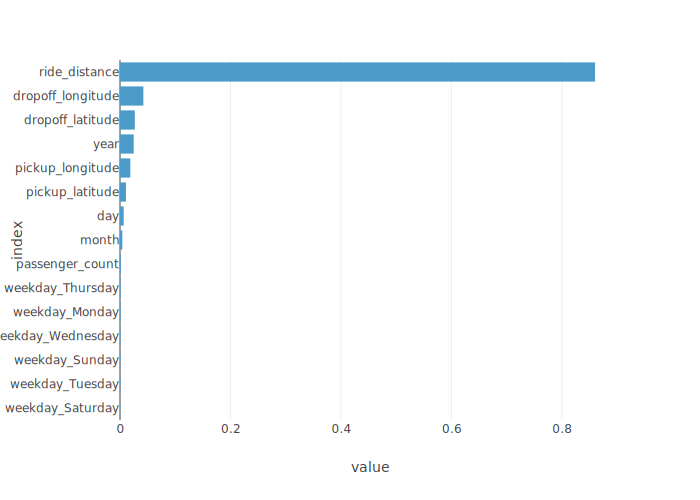

In [24]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

**To estimate the fare, the ride distance is by far the most important feature! That seems fair 😌**

14. Would the model be able to make good predictions if we hadn't included the ride distance by hand? Train a new Random Forest model (with grid search) by dropping the `ride_distance` column from the features, and conclude.

In [26]:
# Drop ride_distance
X = X.drop('ride_distance', axis = 1)

In [27]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day']
Found categorical features  ['weekday']


In [28]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [29]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() 

In [30]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [31]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [32]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore

Performing preprocessings on train set...
       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
8152         -73.966328        40.757692         -73.958325         40.768067   
1380         -73.988100        40.764807         -74.001052         40.746947   
14079        -74.003445        40.743692         -74.005457         40.738923   
7725         -73.961230        40.760852         -73.957473         40.722320   
14918        -73.966034        40.767998         -73.954902         40.783116   

       passenger_count  year  month  day    weekday  
8152                 1  2012      2   16   Thursday  
1380                 1  2013     10   23  Wednesday  
14079                1  2009      5   22     Friday  
7725                 1  2013     11   10     Sunday  
14918                1  2014      4    2  Wednesday  
...Done.
[[-0.14344502  0.14080045 -0.14430518  0.12085588 -0.52674365  0.14178757
  -1.22949054  0.03136581  0.          0.          0.          1

In [33]:
# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [10, 12, 14],
    'min_samples_split': [4, 8],
    'n_estimators': [60, 80, 100]
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3, verbose = 2)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.6s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.5s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=60; total time=   2.5s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.4s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.4s
[CV] END .max_depth=10, min_samples_split=4, n_estimators=80; total time=   3.4s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_split=4, n_estimators=100; total time=   4.3s
[CV] END .max_depth=10, min_samples_split=8, n_estimators=60; total time=   2.6s
[CV] END .max_depth=10, min_samples_split=8, n_estimators=60; total time=   2.6s
[CV] END .max_depth=10, min_sampl

In [34]:
# Print R^2 scores
print("R2 score on training set : ", gridsearch.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch.score(X_test, Y_test))

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# Print MAE
print("Mean Absolute Error on training set : ", mean_absolute_error(Y_train, Y_train_pred))
print("Mean Fare on training set : ", Y_train.mean())
print()
print("Mean Absolute Error on test set : ", mean_absolute_error(Y_test, Y_test_pred))
print("Mean Fare on test set : ", Y_test.mean())
print("Standard-deviation on test set : ", Y_test.std())

R2 score on training set :  0.850107087831722
R2 score on test set :  0.713239229422019
Predictions on training set...
...Done.
[ 7.45782206  8.61356464  7.42620888 ...  7.48197772 25.77105996
  8.8216215 ]

Predictions on test set...
...Done.
[14.02542084  8.62151493  7.51974234 ...  7.44094536  7.82347779
  8.03063538]

Mean Absolute Error on training set :  2.4255949901205986
Mean Fare on training set :  11.330150643830464

Mean Absolute Error on test set :  2.860988261156146
Mean Fare on test set :  11.481740000000038
Standard-deviation on test set :  9.631479542206511


**Without the ride distance explicitely included as an input feature in the model, the performances are still way better than the baseline! This happens thanks to the non-linearity of Random Forest. The model is able to extract from the GPS coordinates some information that is somehow correlated with the ride distance. However, the predictions are not as good as the ones obtained before, which shows the importance of feature engineering, as Random Forest is limited by the type of functions it can approximate.**